For Basics Check the [1st Notebook](https://github.com/suvoooo/Learn-TensorFlow/blob/master/TF-Proba/Norm-Flows/Normalizing%20Flows_GettingStarted.ipynb): 


What topics are covered before: 
1. Probability & Linear Algebra; 
2. Change of Variable and Jacobian;
3. Example of Bijection operations: Forward and Inverse Method w TensorFlow Probability.  


Let's review few things we have already seen, specially in relation to bijection and change of variables formula. 

The two main formulas that we went through step by step are--

$$\text{log}\, p_X(x) = \log p_U(u) − log|\det \, J_ϕ (u)|\, ......\, (eq: 1)$$

where We remember our transformation from $u$ to $x$ via mapping function $ϕ$ as $x=ϕ(u);\, u=ϕ^{-1}\, (x)$

$$\log p_U(u) = \log p_X(x) − \log |\det J_{ϕ^{−1}}(x)|\, ......\, (eq: 2)$$

We also verified these equations through a simple example as below: 

In [1]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.ticker as tick
import seaborn as sns 


import tensorflow as tf
import tensorflow_probability as tfp


tfd = tfp.distributions
tfb = tfp.bijectors

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path_to_file='/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
normal_dist = tfd.Normal(loc=0., scale=2.0)

z = normal_dist.sample(5)
print ('check initial z: ', z)

log_prob_z = normal_dist.log_prob(z) 
print('check log probability of z; ', log_prob_z)


### chain two simple bijection operation together
scale_b = tfb.Scale(2.) # define a scale bijector
shift_b = tfb.Shift(3.)
scale_shift_b = tfb.Chain([scale_b, shift_b]) # operates from right to left, 1st is shift


x_chain = scale_shift_b.forward(z)
print ('check z after shift (3) + scale (2): ', x_chain)


log_prob_x_chain = log_prob_z - scale_shift_b.forward_log_det_jacobian(z)
print ('log prob of new variable from change of variable rule (forward): ', log_prob_x_chain)
log_prob_x_inv = log_prob_z + scale_shift_b.inverse_log_det_jacobian(x_chain)
print ('log prob of new variable from change of variable rule (inverse): ', log_prob_x_inv)

check initial z:  tf.Tensor([ 0.5936408   2.4505558  -0.82439744  2.5028672   1.99037   ], shape=(5,), dtype=float32)
check log probability of z;  tf.Tensor([-1.6561369 -2.3627386 -1.6970396 -2.3951287 -2.1072824], shape=(5,), dtype=float32)
check z after shift (3) + scale (2):  tf.Tensor([ 7.1872816 10.901112   4.351205  11.005734   9.98074  ], shape=(5,), dtype=float32)
log prob of new variable from change of variable rule (forward):  tf.Tensor([-2.3492842 -3.0558858 -2.3901868 -3.088276  -2.8004296], shape=(5,), dtype=float32)
log prob of new variable from change of variable rule (inverse):  tf.Tensor([-2.3492842 -3.0558858 -2.3901868 -3.088276  -2.8004296], shape=(5,), dtype=float32)


Let's see the Eq. 2 and the code again for direct comparison: 

$$\log p_X(x) = \log p_U(u) + \log |\det J_{ϕ^{−1}}(x)|\, ......\, (eq: 2)$$

Code: 

`log_prob_x = log_prob_z + scale_shift_b.inverse_log_det_jacobian(x)`

For calculating log probability of $x$ here we are still using the variable $z$ (in our equation it is $u$). We can also tweak it a little bit to write it using only $x$. 

Since we reached to $x$ by starting from $z$ (samples from normal distribution) via the forward transformation of the bijector, we can use the inverse of $x$ to replace $z$. Let's see the block below: 

In [ ]:
##### how it was before
log_prob_x = log_prob_z + scale_shift_b.inverse_log_det_jacobian(x_chain)
print ('log prob of new variable from change of variable rule (with z): ', log_prob_x)

##### Now with only x, we replace log_prob_z
# log_prob_z = normal_dist.log_prob(z)
# log_prob_z = normal_dist.log_prob(scale_shift_b.inverse(x))

log_prob_x_w_x = normal_dist.log_prob(scale_shift_b.inverse(x_chain)) + scale_shift_b.inverse_log_det_jacobian(x_chain)
print ('log prob of new variable from change of variable rule (with only x): ', log_prob_x_w_x)

log prob of new variable from change of variable rule (with z):  tf.Tensor([-2.3492842 -3.0558858 -2.3901868 -3.088276  -2.8004296], shape=(5,), dtype=float32)
log prob of new variable from change of variable rule (with only x):  tf.Tensor([-2.3492842 -3.0558858 -2.3901868 -3.088276  -2.8004296], shape=(5,), dtype=float32)


Why is this necessary? 

Normalizing flow is basically a generative model of the data. We start with a latent variable $z$ (simple distribution, also known as base distribution). Data generating process first samples $z$ from the base distribution and transform it according to a function (say $\phi$) to reach $x, x = \phi (z)$. For normalizing flow, the function $(\phi)$ is bijective i.e. inverse transformation is always possible.   This function will be parametrized and we need to _learn_ the best parameters via maximum likelihood estimation. This implies during the training process we have $x$ as the training data points and we would like to calculate the log probability of $x$, because this is what we would like to maximize and the bijector object contains the parameters that our network will learn during training. Once this part is done then we can sample from the model by sampling from the base distribution first and then passing that sample through the forward bijector transformation. 



```
log_prob_x = base_dist.log_prob(bijector.inverse(x)) + bijector.inverse_log_det_jacobian(x) 

x_sample = bijector.forward(base_dist.sample())

```

Here we will now get started with `TransformedDistribution` which to quote from the documentation:



> It models $p(y)$ given a base distribution $p(x)$, and a deterministic, invertible, differentiable transform, $Y = g(X)$. The transform is typically an instance of the `Bijector` class and the base distribution is typically an instance of the `Distribution` class.



In [ ]:
### Getting Started with TransformDistribution class. 
tf.random.set_seed(1234)


normal_dist = tfd.Normal(loc=0, scale=1.) # starting base distribution
z = normal_dist.sample(5, seed=10)

## bijector 

exp = tfb.Exp()
x = exp.forward(z)
log_prob_x = normal_dist.log_prob(exp.inverse(x)) + exp.inverse_log_det_jacobian(x) # using the formula before

#### we can combine these steps in TransformDistribution. 
tf.random.set_seed(1234)
log_normal = tfd.TransformedDistribution(normal_dist, exp)
log_normal_sample = log_normal.sample(5, seed=10)
log_normal_sample_lp = log_normal.log_prob(x) # way easier to find log prob like this, than remembering the formula above

print ('check without Transform Distribution & w TransformDistribution: ', x, '\n', log_normal_sample)
print ('check log probs without Transform Distribution & w TransformDistribution: ', log_prob_x, '\n', log_normal_sample_lp)

check without Transform Distribution & w TransformDistribution:  tf.Tensor([1.646678   0.7789296  0.44211158 1.5840847  4.3733983 ], shape=(5,), dtype=float32) 
 tf.Tensor([1.646678   0.7789296  0.44211158 1.5840847  4.3733983 ], shape=(5,), dtype=float32)
check log probs without Transform Distribution & w TransformDistribution:  tf.Tensor([-1.5420791  -0.7003126  -0.43583107 -1.4847485  -3.4830887 ], shape=(5,), dtype=float32) 
 tf.Tensor([-1.5420791  -0.7003126  -0.43583107 -1.4847485  -3.4830887 ], shape=(5,), dtype=float32)


`TransformedDistribution.sample()` : First sample from the base distribution and then apply the bijector. 

`TransformedDistribution.log_prob()` : The inverse formula with log det jacobian is applied to the transformed variable $(x)$. 

Below we can also plot the distributions, for this we increase the sample size from 5. Since eventually our transformed distribution is lognormal, we can also verify how the distribution looks like by calling the `LogNormal` distribution.    

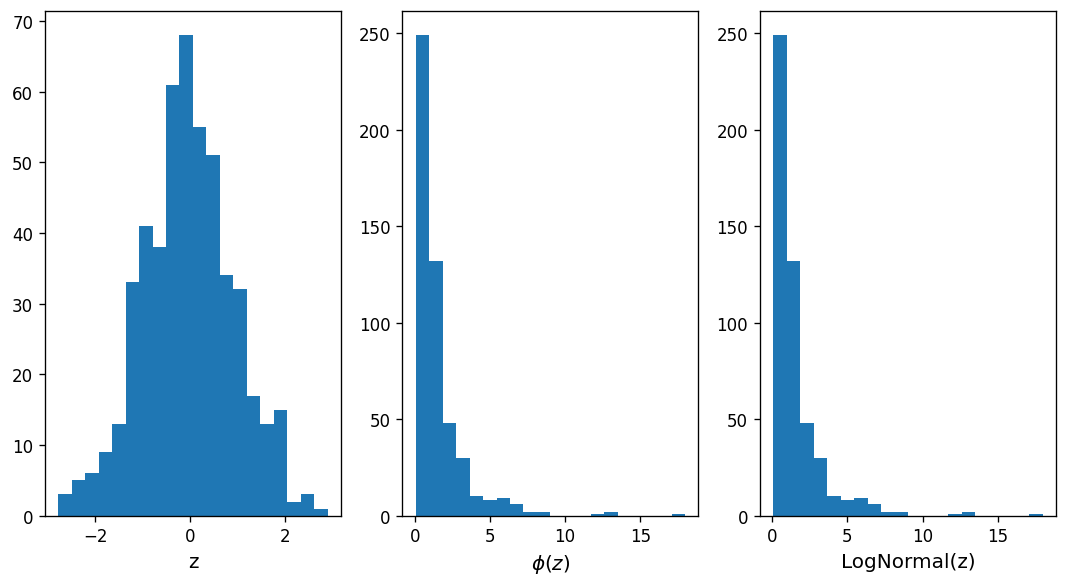

In [ ]:
tf.random.set_seed(1234)

sample_s = 500

normal_dist = tfd.Normal(loc=0, scale=1.) # starting base distribution
z = normal_dist.sample(sample_s, seed=10)

tf.random.set_seed(1234)
log_normal = tfd.TransformedDistribution(normal_dist, exp)
log_normal_sample = log_normal.sample(sample_s, seed=10)

tf.random.set_seed(1234)
tf_log_normal = tfd.LogNormal(loc=0, scale=1.)
tf_log_normal_sample = tf_log_normal.sample(sample_s, seed=10)

fig = plt.figure(figsize=(9, 5))
fig.add_subplot(131)
plt.hist(z, bins=20)
plt.xlabel('z', fontsize=12)
fig.add_subplot(132)
plt.hist(log_normal_sample, bins=20)
plt.xlabel(r'$\phi(z)$', fontsize=12)
fig.add_subplot(133)
plt.hist(tf_log_normal_sample, bins=20)
plt.xlabel('LogNormal(z)', fontsize=12)
plt.tight_layout()
plt.show()

#### Defining Custom Bijector 

This is pretty similar to defining custom layer in keras. 

For defining a new layer we subclass the keras layer class as below--



```
from keras.layer import Layer

class CustomLayer(Layer):
   .... 
```

Here we will subclass the tensroflow bijector class. 

Let's define $f(x) = (ax)^3 $, this would be our forward method for the bijector given some input tensor $x$ and a constant multiplicative factor $a$. 

$\log\, \left(\frac{d}{dx}\, (ax)^3 \right) = \log\, (3a\, (ax)^2) = \log (3a) + 2\, \log (ax)$. ..... (1)

Similarly, $f(x) = (ax)^{\frac{3}{2}}$, 

$\log\, \left(\frac{d}{dx}\, (ax)^{3/2} \right) = \log\, (1.5a\, (ax)^{0.5}) = \log (1.5a) + 0.5\, \log (ax)$. ..... (2)


For defning the bijector classes, I've followed the structure in the [`tfp.bijectors.power`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Power) as described in the GitHub source code. It's also highlighted that in power bijector odd integers are not supported:

**Powers that are reciprocal of odd integers like 1. / 3 are not supported because of numerical precision issues that make this property difficult to test. In order to simulate this behavior, we recommend using the Invert bijector instead (i.e. instead of tfb.Power(power=1./3) use tfb.Invert(tfb.Power(power=3.))).**


!!!Examples below are just for our own understanding!!!

In [ ]:
class Mult_Cube(tfb.Bijector): # subclassing bijector module
  """
  forward transformation: Multiply with a constant number & compute result ** 3.  
  """
  def __init__(self, a, validate_args='False', name='Cubic'):
    self.a = tf.cast(a, tf.float32)
    if validate_args:
      assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-6), tf.float32)) == 1.0
    super(Mult_Cube, self).__init__(validate_args=validate_args, name=name, forward_min_event_ndims=0) # forward_min_event_ndims mandatory to mention

  def _forward(self, y):
    y = tf.cast(y, tf.float32)
    return tf.squeeze(tf.pow(self.a*y, 3))     

  def _inverse(self, x):
    x = tf.cast(x, tf.float32)
    return (tf.math.sign(x) * tf.pow(tf.abs(x), 1/3))/self.a  

  def _forward_log_det_jacobian(self, y):
    y = tf.cast(y, tf.float32)
    return tf.math.log(3* tf.abs(self.a)) + 2* tf.math.log(tf.abs(self.a * y)) # equation 1 before
  def _inverse_log_det_jacobian(self, x):
     # automatically implemented
     return -self._forward_log_det_jacobian(self._inverse(x))

In [ ]:
class Mult_quad(tfb.Bijector): # subclassing bijector module
  """
  forward transformation: Multiply with a constant number & compute result ** 4 + shift.  
  """
  def __init__(self, a, b, validate_args='False', name='Quad'):
    self.a = tf.cast(a, tf.float32)
    self.b = tf.cast(b, tf.float32)
    if validate_args:
      assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-6), tf.float32)) == 1.0
      assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-6), tf.float32)) == 1.0
    super(Mult_quad, self).__init__(validate_args=validate_args, name=name, forward_min_event_ndims=0) # forward_min_event_ndims mandatory to mention

  def _forward(self, y):
    y = tf.cast(y, tf.float32)
    return tf.squeeze(tf.pow(self.a*y, 4) + self.b)     

  def _inverse(self, x):
    x = tf.cast(x, tf.float32)
    return tf.pow(x - self.b, 1/4)/self.a  

  def _forward_log_det_jacobian(self, y):
    y = tf.cast(y, tf.float32)
    return tf.math.log(4* tf.abs(self.a)) + 3* tf.math.log(tf.abs(self.a * y)) 
  def _inverse_log_det_jacobian(self, x):
     # automatically implemented
     return -self._forward_log_det_jacobian(self._inverse(x))

In [ ]:
class Mult_Power(tfb.Bijector): # subclassing bijector module
  """
  forward transformation: Multiply with a constant number & compute result ** 3/2.  
  """
  def __init__(self, a, validate_args='False', name='Cubic'):
    self.a = tf.cast(a, tf.float32)
    if validate_args:
      assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-6), tf.float32)) == 1.0
    super(Mult_Power, self).__init__(validate_args=validate_args, name=name, forward_min_event_ndims=0) # forward_min_event_ndims mandatory to mention

  def _forward(self, y):
    y = tf.cast(y, tf.float32)
    return tf.squeeze(tf.pow(self.a*y, 3/2))     

  def _inverse(self, x):
    x = tf.cast(x, tf.float32)
    return (tf.math.sign(x) * tf.pow(tf.abs(x), 2/3))/self.a  

  def _forward_log_det_jacobian(self, y):
    y = tf.cast(y, tf.float32)
    return tf.math.log(1.5* tf.abs(self.a)) + 0.5* tf.math.log(tf.abs(self.a * y)) # equation 2 before
  def _inverse_log_det_jacobian(self, x):
     # automatically implemented
     return -self._forward_log_det_jacobian(self._inverse(x))

In [ ]:

Mult_cube_call = Mult_Cube([2.0], validate_args=True) # a = 2.0
x=tf.constant([[1., 0], [2, 1]])  
x_f = Mult_cube_call.forward(x) # expected result (ax)**3 for every element
print(x_f)
x_f_i = Mult_cube_call.inverse(x_f) # back to original x at this point
print (x_f_i, '\n', 'starting tensor: ', x)
print(Mult_cube_call)


# Mult_power_call = Mult_Power([2.0], validate_args=True) # a = 2.0
# x_f = Mult_power_call.forward(x) # expected result (ax)**(3/2) for every element
# print(x_f)
# x_f_i = Mult_power_call.inverse(x_f)
# print (x_f_i, '\n', 'starting tensor: ', x)
# print(Mult_power_call)



Mult_quad_call = Mult_quad([2.0], [1.0], validate_args=True) # a = 2.0, b=1
x=tf.constant([[1., 0], [2, 1]])
x_q = Mult_quad_call.forward(x) 
x_q_inv = Mult_quad_call.inverse(x)
print('forward: ', x_q)
print ('inverse: ', x_q_inv)
x_q_i = Mult_quad_call.inverse(x_q)
print (x_q_i, '\n', 'starting tensor: ', x)
print(Mult_quad_call)

tf.Tensor(
[[ 8.  0.]
 [64.  8.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1. 0.]
 [2. 1.]], shape=(2, 2), dtype=float32) 
 starting tensor:  tf.Tensor(
[[1. 0.]
 [2. 1.]], shape=(2, 2), dtype=float32)
tfp.bijectors.Mult_Cube("Cubic", min_event_ndims=0)
forward:  tf.Tensor(
[[ 17.   1.]
 [257.  17.]], shape=(2, 2), dtype=float32)
inverse:  tf.Tensor(
[[0.  nan]
 [0.5 0. ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1. 0.]
 [2. 1.]], shape=(2, 2), dtype=float32) 
 starting tensor:  tf.Tensor(
[[1. 0.]
 [2. 1.]], shape=(2, 2), dtype=float32)
tfp.bijectors.Mult_quad("Quad", min_event_ndims=0)


(200,)
(200, 1)


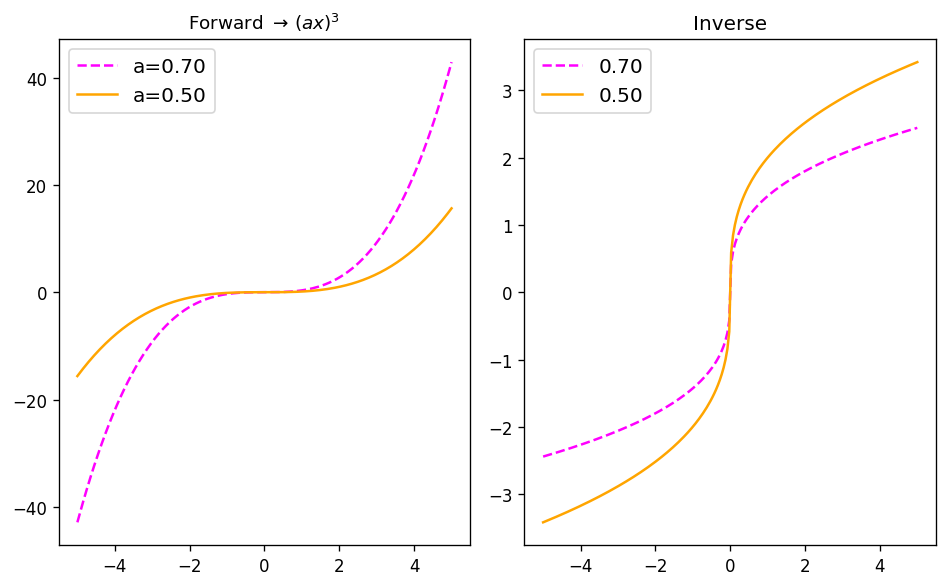

In [ ]:
a = [0.7, 0.5]
Mult_cube_call = Mult_Cube(a, validate_args = True)
x = np.linspace(-5, 5, 200)
print (x.shape)
x = x.reshape(-1, 1)
print (x.shape)

fig = plt.figure(figsize=(8, 5))
fig.add_subplot(121)
plt.plot(x, Mult_cube_call.forward(x)[:, 0], color='magenta', ls='--', label='a={:.2f}'.format(a[0]))
plt.plot(x, Mult_cube_call.forward(x)[:, 1], color='orange', ls='-', label='a={:.2f}'.format(a[1]))
plt.legend(fontsize=12)
plt.title(r'Forward $\rightarrow\, (ax)^3$', fontsize=11)
fig.add_subplot(122)
plt.plot(x, Mult_cube_call.inverse(x)[:, 0], color='magenta', ls='--', label='{:.2f}'.format(a[0]))
plt.plot(x, Mult_cube_call.inverse(x)[:, 1], color='orange', ls='-', label='{:.2f}'.format(a[1]))
plt.legend(fontsize=12)
plt.title('Inverse')
plt.tight_layout()
plt.savefig(path_to_file + 'NormFlow_Mult_Cube.png', dpi = 200)
plt.show()

(200,)
(200, 1)


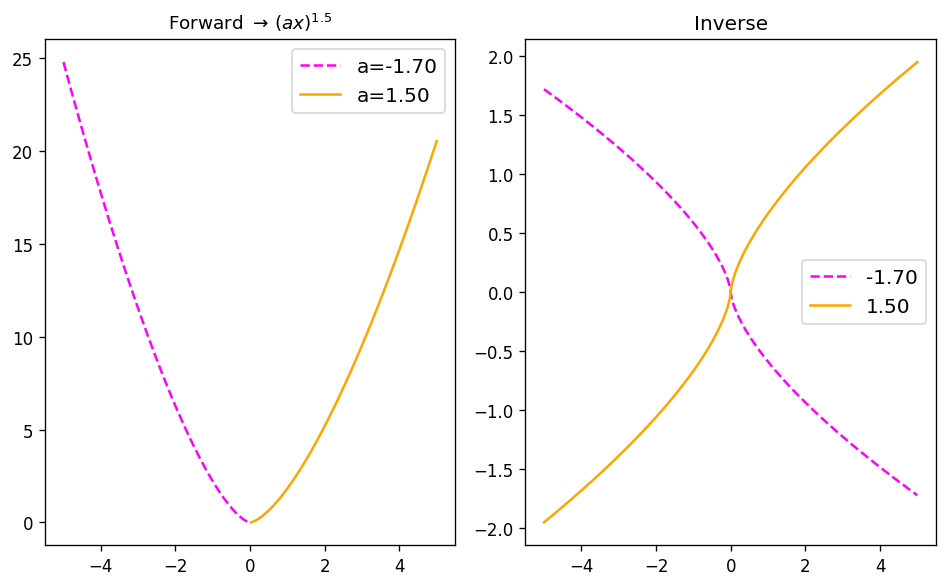

In [ ]:
a = [-1.7, 1.5]
Mult_power_call = Mult_Power(a, validate_args = True)
x = np.linspace(-5, 5, 200)
print (x.shape)
x = x.reshape(-1, 1)
print (x.shape)

fig = plt.figure(figsize=(8, 5))
fig.add_subplot(121)
plt.plot(x, Mult_power_call.forward(x)[:, 0], color='magenta', ls='--', label='a={:.2f}'.format(a[0]))
plt.plot(x, Mult_power_call.forward(x)[:, 1], color='orange', ls='-', label='a={:.2f}'.format(a[1]))
plt.legend(fontsize=12)
plt.title(r'Forward $\rightarrow \, (ax)^{1.5}$', fontsize=11)
fig.add_subplot(122)
plt.plot(x, Mult_power_call.inverse(x)[:, 0], color='magenta', ls='--', label='{:.2f}'.format(a[0]))
plt.plot(x, Mult_power_call.inverse(x)[:, 1], color='orange', ls='-', label='{:.2f}'.format(a[1]))
plt.legend(fontsize=12)
plt.title('Inverse')
plt.tight_layout()
plt.savefig(path_to_file  + 'NormFlow_Power.png', dpi=200)
plt.show()
# print (Mult_power_call.forward(x)[:, 0])

(200,)
(200, 1)


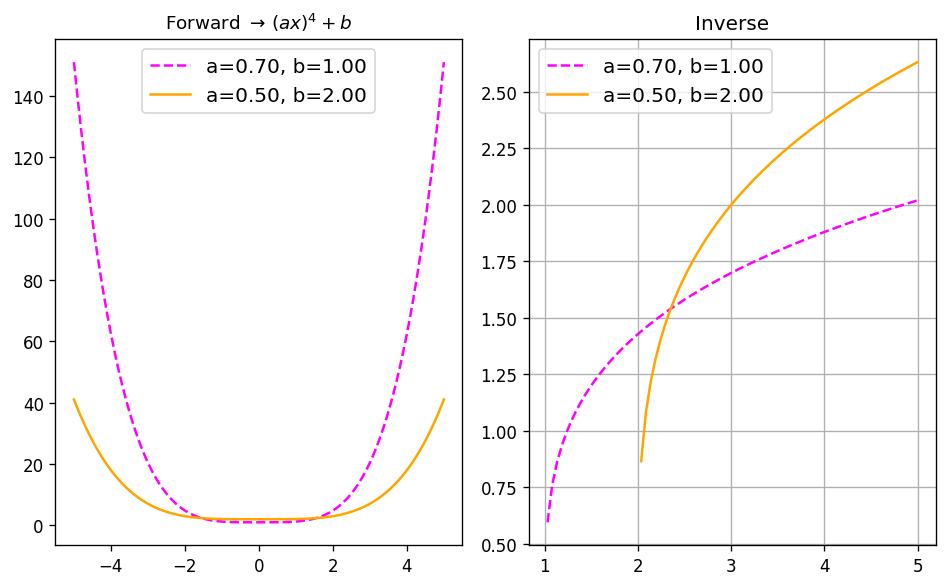

In [ ]:
a = [0.7, 0.5] # scale
b = [1, 2] # shift

Mult_quad_call = Mult_quad(a, b, validate_args = True)
x = np.linspace(-5, 5, 200)
print (x.shape)
x = x.reshape(-1, 1)
print (x.shape)

fig = plt.figure(figsize=(8, 5))
fig.add_subplot(121)
plt.plot(x, Mult_quad_call.forward(x)[:, 0], color='magenta', ls='--', label='a={:.2f}, b={:.2f}'.format(a[0], b[0]))
plt.plot(x, Mult_quad_call.forward(x)[:, 1], color='orange', ls='-', label='a={:.2f}, b={:.2f}'.format(a[1], b[1]))
plt.legend(fontsize=12)
plt.title(r'Forward $\rightarrow\, (ax)^4 + b$', fontsize=11)
fig.add_subplot(122)
plt.plot(x, Mult_quad_call.inverse(x)[:, 0], color='magenta', ls='--', label='a={:.2f}, b={:.2f}'.format(a[0], b[0]))
plt.plot(x, Mult_quad_call.inverse(x)[:, 1], color='orange', ls='-', label='a={:.2f}, b={:.2f}'.format(a[1], b[1]))
plt.legend(fontsize=12)
plt.title('Inverse')
plt.grid(True)
plt.tight_layout()
# plt.savefig(path_to_file + 'NormFlow_Mult_quad.png', dpi = 200)
plt.show()

(200,)
(200, 1)


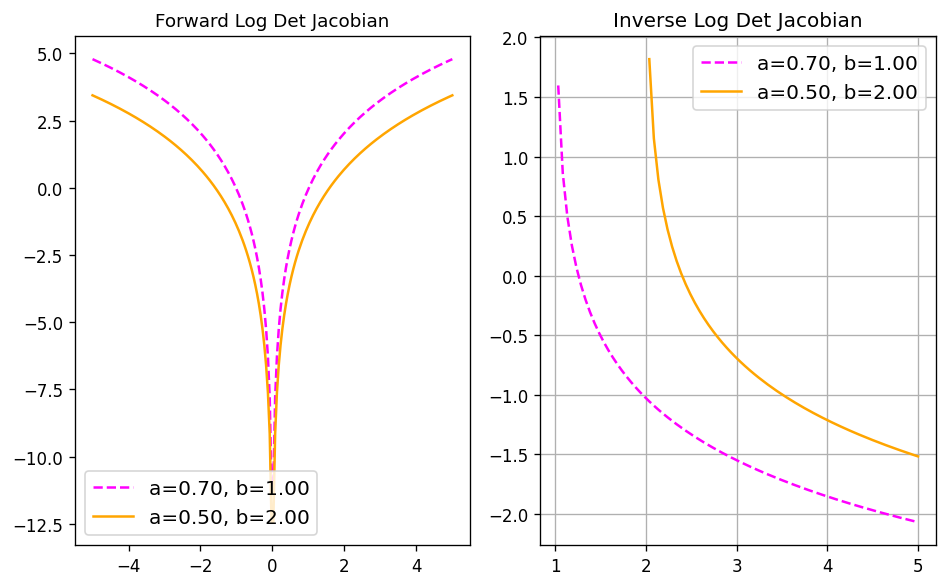

In [ ]:
a = [0.7, 0.5] # scale
b = [1, 2] # shift

Mult_quad_call = Mult_quad(a, b, validate_args = True)
x = np.linspace(-5, 5, 200)
print (x.shape)
x = x.reshape(-1, 1)
print (x.shape)

fig = plt.figure(figsize=(8, 5))
fig.add_subplot(121)
plt.plot(x, Mult_quad_call.forward_log_det_jacobian(x)[:, 0], color='magenta', ls='--', label='a={:.2f}, b={:.2f}'.format(a[0], b[0]))
plt.plot(x, Mult_quad_call.forward_log_det_jacobian(x)[:, 1], color='orange', ls='-', label='a={:.2f}, b={:.2f}'.format(a[1], b[1]))
plt.legend(fontsize=12)
plt.title(r'Forward Log Det Jacobian', fontsize=11)
fig.add_subplot(122)
plt.plot(x, Mult_quad_call.inverse_log_det_jacobian(x)[:, 0], color='magenta', ls='--', label='a={:.2f}, b={:.2f}'.format(a[0], b[0]))
plt.plot(x, Mult_quad_call.inverse_log_det_jacobian(x)[:, 1], color='orange', ls='-', label='a={:.2f}, b={:.2f}'.format(a[1], b[1]))
plt.legend(fontsize=12)
plt.title('Inverse Log Det Jacobian')
plt.grid(True)
plt.tight_layout()
# plt.savefig(path_to_file + 'NormFlow_Mult_quad.png', dpi = 200)
plt.show()

(200,)
(200, 1)


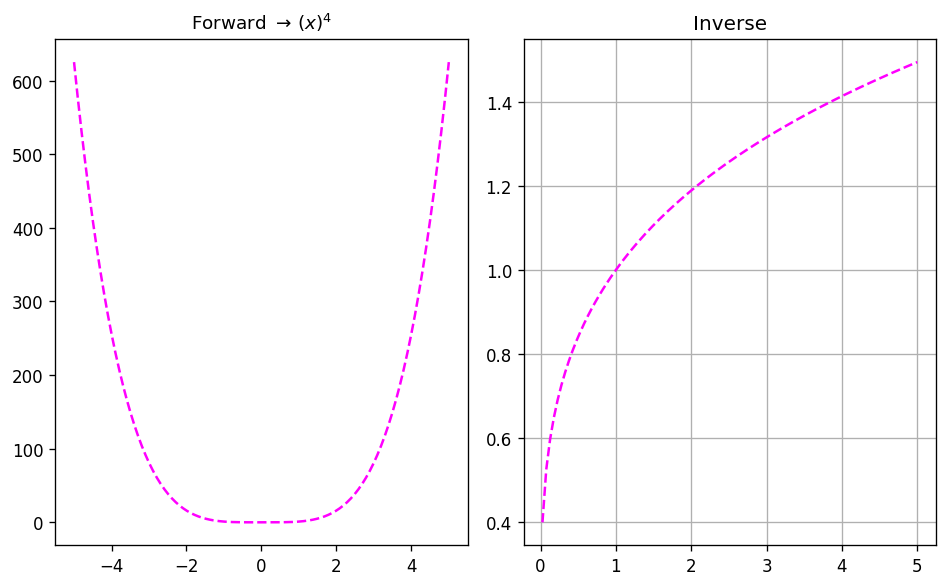

In [ ]:
#### compare this with tfb.power

x = np.linspace(-5, 5, 200)
print (x.shape)
x = x.reshape(-1, 1)
print (x.shape)

fig = plt.figure(figsize=(8, 5))
fig.add_subplot(121)
plt.plot(x, tfb.Power(4).forward(x)[:, 0], color='magenta', ls='--', )
# plt.legend(fontsize=12)
plt.title(r'Forward $\rightarrow\, (x)^4$', fontsize=11)
fig.add_subplot(122)
plt.plot(x, tfb.Power(4).inverse(x)[:, 0], color='magenta', ls='--', )
# plt.legend(fontsize=12)
plt.title('Inverse')
plt.grid(True)
plt.tight_layout()
# plt.savefig(path_to_file + 'NormFlow_Mult_quad.png', dpi = 200)
plt.show()

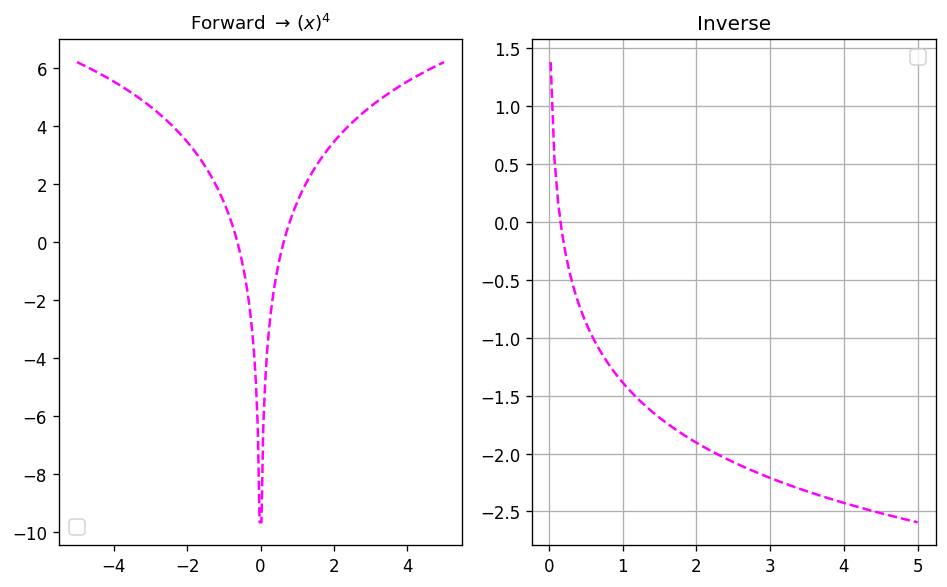

In [ ]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(121)
plt.plot(x, tfb.Power(4).forward_log_det_jacobian(x)[:, 0], color='magenta', ls='--', )
plt.legend(fontsize=12)
plt.title(r'Forward $\rightarrow\, (x)^4$', fontsize=11)
fig.add_subplot(122)
plt.plot(x, tfb.Power(4).inverse_log_det_jacobian(x)[:, 0], color='magenta', ls='--', )
plt.legend(fontsize=12)
plt.title('Inverse')
plt.grid(True)
plt.tight_layout()
# plt.savefig(path_to_file + 'NormFlow_Mult_quad.png', dpi = 200)
plt.show()

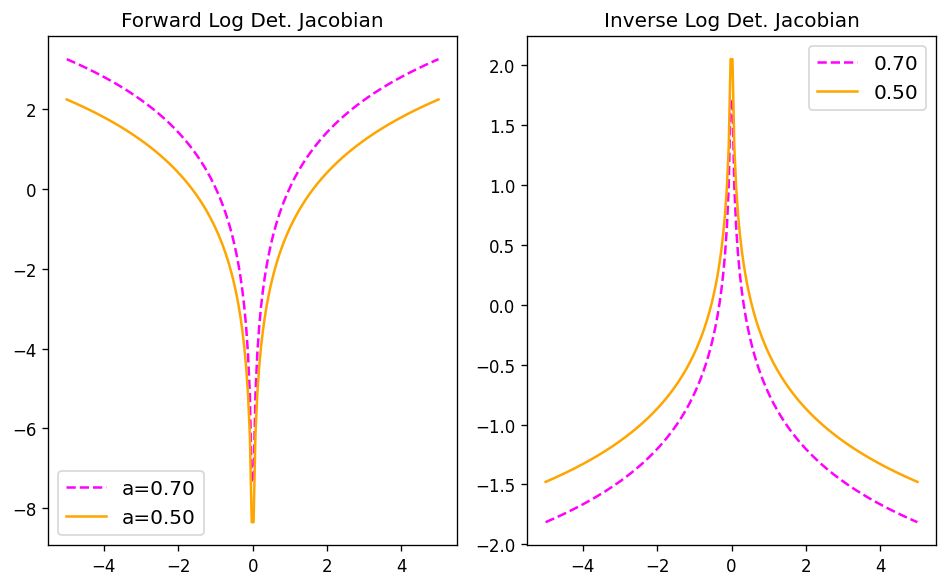

In [ ]:
a = [0.7, 0.5]
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(121)
plt.plot(x, Mult_cube_call.forward_log_det_jacobian(x)[:, 0], color='magenta', ls='--', label='a={:.2f}'.format(a[0]))
plt.plot(x, Mult_cube_call.forward_log_det_jacobian(x)[:, 1], color='orange', ls='-', label='a={:.2f}'.format(a[1]))
plt.legend(fontsize=12)
plt.title('Forward Log Det. Jacobian')
fig.add_subplot(122)
plt.plot(x, Mult_cube_call.inverse_log_det_jacobian(x)[:, 0], color='magenta', ls='--', label='{:.2f}'.format(a[0]))
plt.plot(x, Mult_cube_call.inverse_log_det_jacobian(x)[:, 1], color='orange', ls='-', label='{:.2f}'.format(a[1]))
plt.legend(fontsize=12)
plt.title('Inverse Log Det. Jacobian')
plt.tight_layout()
plt.savefig(path_to_file + 'NormFlow_Mult_Cube_Fwd_Logdet.png', dpi = 200)
plt.show()

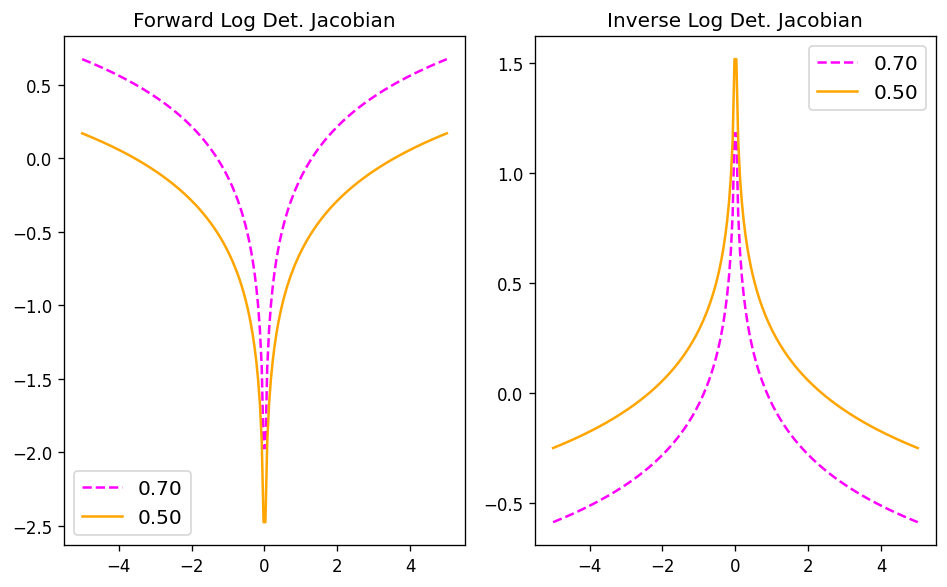

In [ ]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(121)
plt.plot(x, Mult_power_call.forward_log_det_jacobian(x)[:, 0], color='magenta', ls='--', label='{:.2f}'.format(a[0]))
plt.plot(x, Mult_power_call.forward_log_det_jacobian(x)[:, 1], color='orange', ls='-', label='{:.2f}'.format(a[1]))
plt.legend(fontsize=12)
plt.title('Forward Log Det. Jacobian')
fig.add_subplot(122)
plt.plot(x, Mult_power_call.inverse_log_det_jacobian(x)[:, 0], color='magenta', ls='--', label='{:.2f}'.format(a[0]))
plt.plot(x, Mult_power_call.inverse_log_det_jacobian(x)[:, 1], color='orange', ls='-', label='{:.2f}'.format(a[1]))
plt.legend(fontsize=12)
plt.title('Inverse Log Det. Jacobian')
plt.tight_layout()
plt.savefig(path_to_file + 'NormFlow_Power_Fwd_Logdet.png', dpi = 200)
plt.show()

Now we can check the effect of Bijector on a distribution. 
For this we will use `Transformed`

check sample shape:  (400,) (400,)
tfp.distributions._TransformedDistribution("CubicSampleNormal", batch_shape=[], event_shape=[2], dtype=float32)
cubed normal sample shape:  (400, 2) (400, 2)


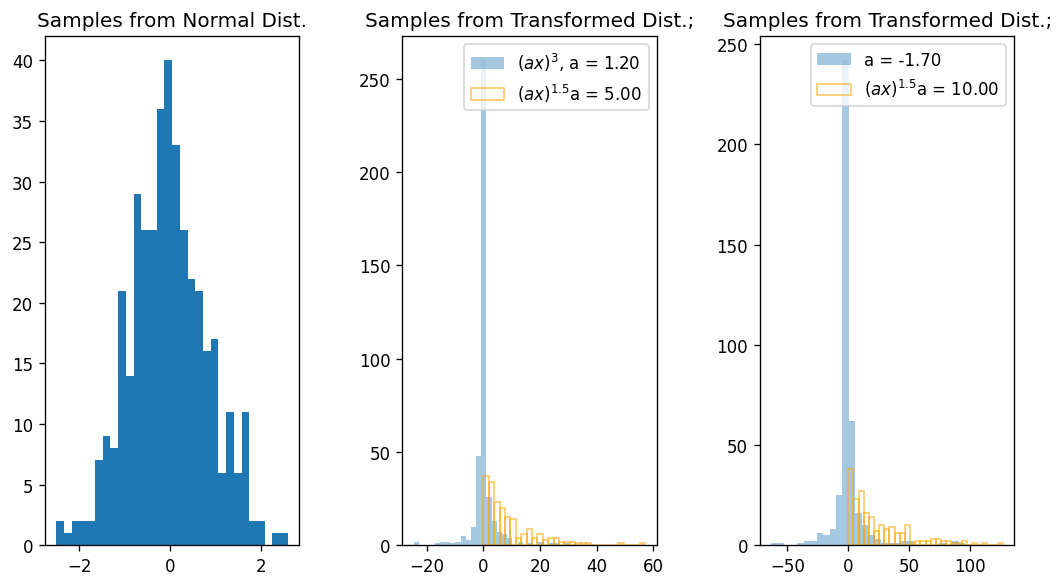

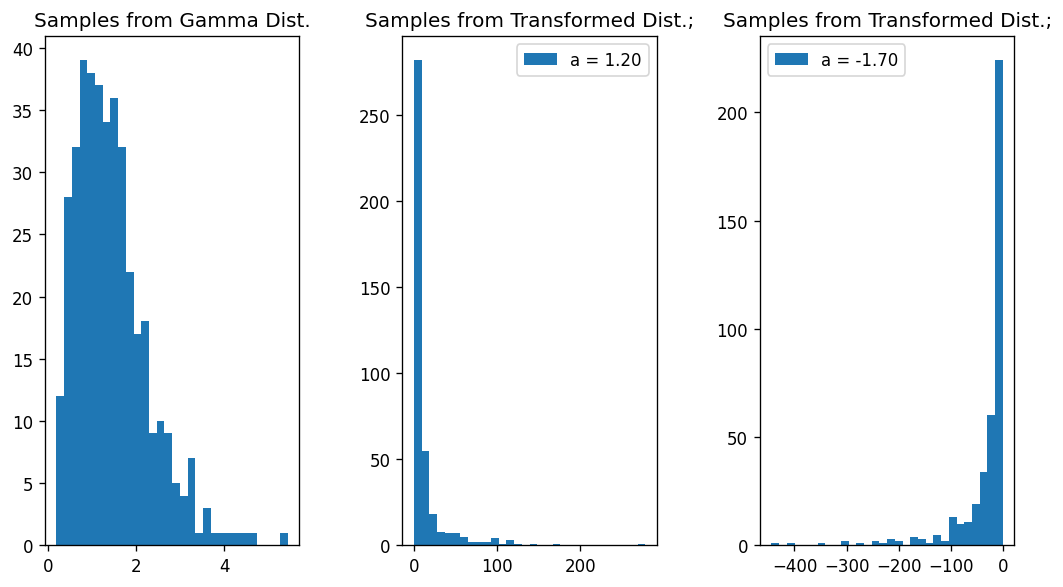

In [ ]:
tf.random.set_seed(1234)
normal_dist = tfd.Normal(loc=0.0, scale=0.9) # starting base distribution
gamma_dist = tfd.Gamma(concentration=3.0, rate=2.0)
z = normal_dist.sample(400, seed=10,)
z_g = gamma_dist.sample(400, seed=10,)
# z = tf.reshape(z, (-1, 1))
print ('check sample shape: ', z.shape, z_g.shape)

tf.random.set_seed(1234)
a = [1.2, -1.7]
a1 = [5, 10]
Mult_cube_call = Mult_Cube(a, validate_args = True)
Mult_power_call = Mult_Power(a1, validate_args=True)
cubed_normal = tfd.TransformedDistribution(tfd.Sample(normal_dist, sample_shape=[2]), Mult_cube_call,)
powered_normal = tfd.TransformedDistribution(tfd.Sample(normal_dist, sample_shape=[2]), Mult_power_call,)
cubed_gamma = tfd.TransformedDistribution(tfd.Sample(gamma_dist, sample_shape=[2]), Mult_cube_call,)
print (cubed_normal)
cubed_normal_sample = cubed_normal.sample(400, seed=10)
powered_normal_sample = powered_normal.sample(400, seed=10)
cubed_gamma_sample = cubed_gamma.sample(400, seed=10)
print ('cubed normal sample shape: ', cubed_normal_sample.shape, powered_normal_sample.shape)

fig = plt.figure(figsize=(9, 5))
fig.add_subplot(131)
plt.hist(z, bins=30)
plt.title('Samples from Normal Dist.')
fig.add_subplot(132)
plt.hist(cubed_normal_sample[..., 0], bins=30, alpha=0.4, label=r'$(ax)^3$, a = {:.2f}'.format(a[0]))
plt.hist(powered_normal_sample[..., 0], bins=30, alpha=0.6, edgecolor='orange',
         label=r'$(ax)^{1.5}$' + 'a = {:.2f}'.format(a1[0]), fill=False) 

plt.title('Samples from Transformed Dist.;')
plt.legend()
fig.add_subplot(133)
plt.hist(cubed_normal_sample[..., 1], bins=30, alpha = 0.4, label='a = {:.2f}'.format(a[1]))
plt.hist(powered_normal_sample[..., 1], bins=30, alpha=0.6, edgecolor='orange',
         label=r'$(ax)^{1.5}$' + 'a = {:.2f}'.format(a1[1]), fill=False)
plt.title('Samples from Transformed Dist.;')
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(9, 5))
fig.add_subplot(131)
plt.hist(z_g, bins=30)
plt.title('Samples from Gamma Dist.')
fig.add_subplot(132)
plt.hist(cubed_gamma_sample[..., 0], bins=30, label='a = {:.2f}'.format(a[0]))
plt.title('Samples from Transformed Dist.;')
plt.legend()
fig.add_subplot(133)
plt.hist(cubed_gamma_sample[..., 1], bins=30, label='a = {:.2f}'.format(a[1]))
plt.title('Samples from Transformed Dist.;')
plt.legend()
plt.tight_layout()
plt.show()

(200, 200) (200, 200)
check stacked shapes:  (200, 200, 2) (200, 200, 2)
prob shape:  (200, 200) (200, 200) (200, 200) (200, 200)


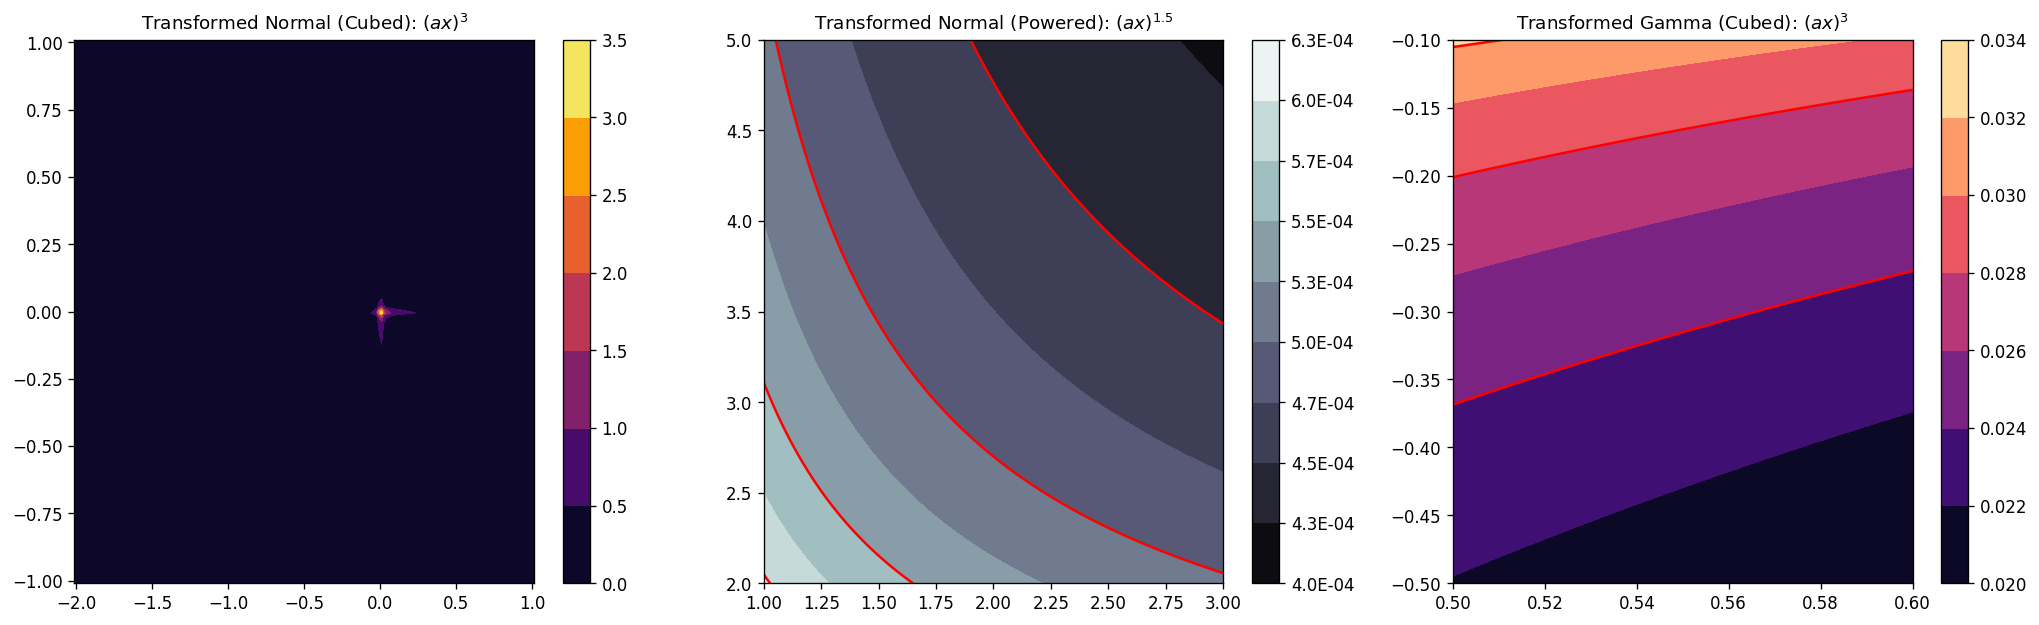

In [ ]:
xx = np.linspace(-2.01, 1.01, 200)
yy = np.linspace(-1.01, 1.01, 200)


xx_g = np.linspace(0.5, 0.6, 200)
yy_g = np.linspace(-0.1, -0.5, 200)

xx_p = np.linspace(1.0, 3, 200)
yy_p = np.linspace(2.0, 5, 200)

X, Y = np.meshgrid(xx, yy)
X_G, Y_G = np.meshgrid(xx_g, yy_g)
X_P, Y_P = np.meshgrid(xx_p, yy_p)


a = [1.20, -1.70]
a1 = [5, 10]

tf.random.set_seed(1234)
normal_dist = tfd.Normal(loc=1., scale=0.9) # starting base distribution
gamma_dist = tfd.Gamma(concentration=3.0, rate=2.0)
Mult_cube_call = Mult_Cube(a, validate_args = True)
Mult_powered_call = Mult_Power(a1, validate_args = True)
cubed_normal = tfd.TransformedDistribution(tfd.Sample(normal_dist, sample_shape=[2]), Mult_cube_call,)
powered_normal = tfd.TransformedDistribution(tfd.Sample(normal_dist, sample_shape=[2]), Mult_powered_call,)
cubed_gamma = tfd.TransformedDistribution(tfd.Sample(gamma_dist, sample_shape=[2]), Mult_cube_call,)


print (X.shape, Y.shape)
stacked_X_Y = np.dstack((X, Y))
stacked_X_Y_G = np.dstack((X_G, Y_G))
stacked_X_Y_P = np.dstack((X_P, Y_P))
print ('check stacked shapes: ', stacked_X_Y.shape, stacked_X_Y_P.shape)
# print (stacked_X_Y)

Z = cubed_normal.prob(stacked_X_Y)
# print (Z[5:10])
Z_G = cubed_gamma.prob(stacked_X_Y_G)
Z_P = powered_normal.prob(stacked_X_Y_P)
Z_N = normal_dist.prob(stacked_X_Y[..., 1])
print ('prob shape: ',  Z.shape, Z_G.shape, Z_P.shape, Z_N.shape)


fig, axs = plt.subplots(1, 3, figsize=(21, 6))
prob_contour = axs[0].contourf(X, Y, Z, cmap=plt.cm.inferno)
fig.colorbar(prob_contour, ax=axs[0])
axs[0].set_title(r'Transformed Normal (Cubed): $(ax)^{3}$', fontsize=11)
prob_contour_p = axs[1].contourf(X_P, Y_P, Z_P, cmap=plt.cm.bone)
CS2 = axs[1].contour(prob_contour_p, levels=prob_contour_p.levels[::2], colors='r',)
axs[1].set_title(r'Transformed Normal (Powered): $(ax)^{1.5}$', fontsize=11)
cbar = fig.colorbar(prob_contour_p, ax=axs[1], )
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1E'))
prob_contour_g = axs[2].contourf(X_G, Y_G, Z_G, cmap=plt.cm.magma)
CS3 = axs[2].contour(prob_contour_g, levels=prob_contour_g.levels[::2], colors='r',)
axs[2].set_title(r'Transformed Gamma (Cubed): $(ax)^{3}$', fontsize=11)
fig.colorbar(prob_contour_g, ax=axs[2], )
plt.savefig(path_to_file + 'NormFlow_Compare_Cmap_Gamma.png', dpi = 200)
plt.show()

#### Normal to Bi-Modal



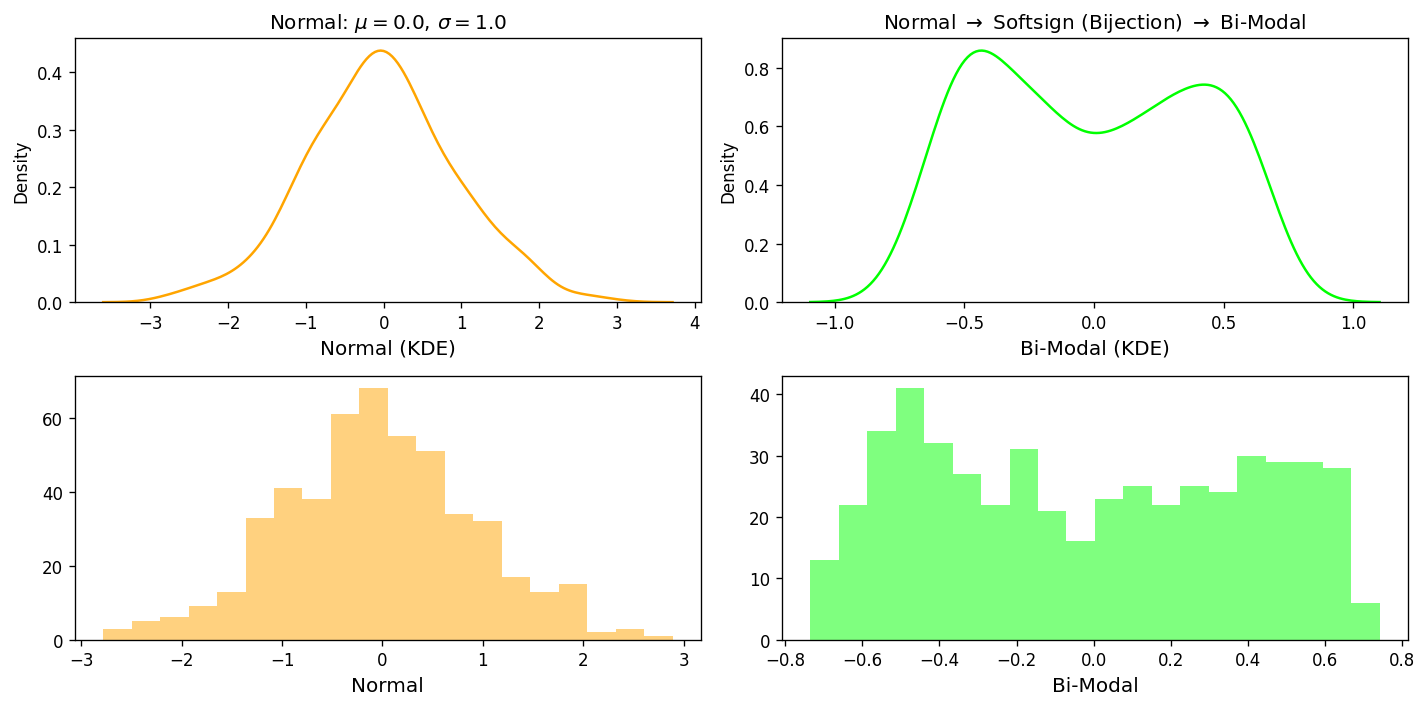

In [19]:


tf.random.set_seed(1234)
normal_dist = tfd.Normal(loc=0., scale=1.0) # starting base distribution
sample_s = 500

normal_dist_sample = normal_dist.sample(sample_s, seed=10)

## bijector 

softsign = tfb.Softsign()



tf.random.set_seed(1234)
bi_modal = tfd.TransformedDistribution(normal_dist, softsign)
bi_modal_sample = bi_modal.sample(sample_s, seed=10)

###### plot histogram

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
sns.kdeplot(ax = axs[0, 0], data = normal_dist_sample, color='orange')
sns.kdeplot(ax = axs[0, 1], data = bi_modal_sample, color='lime')
axs[0, 0].set_xlabel('Normal (KDE)', fontsize=12)
axs[0, 0].set_title(r'Normal: $\mu = 0.0, \, \sigma = 1.0$', fontsize=12)
axs[0, 1].set_xlabel('Bi-Modal (KDE)', fontsize=12)
axs[0, 1].set_title(r'Normal $\rightarrow $ Softsign (Bijection) $\rightarrow$ Bi-Modal', fontsize=12)

axs[1, 0].hist(normal_dist_sample, bins=20, color='orange', alpha=0.5)
axs[1, 1].hist(bi_modal_sample, bins=20, color='lime', alpha=0.5)

axs[1, 0].set_xlabel(r'Normal', fontsize=12)
axs[1, 1].set_xlabel(r'Bi-Modal', fontsize=12)


plt.tight_layout()
plt.savefig(path_to_file + 'NormFlow_Bi-Modal.png', dpi = 200)
plt.show()

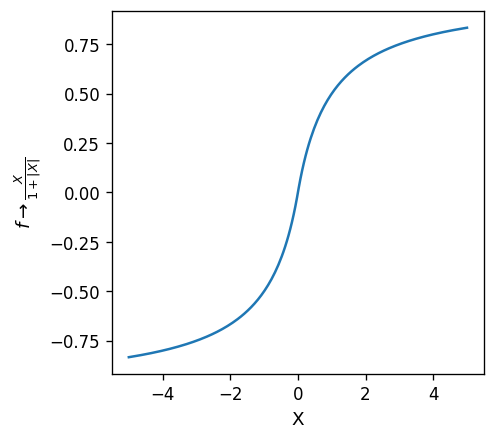

In [17]:
def softsign(x):
  return x/(1+abs(x))

x = np.linspace(-5, 5, 200)
fig = plt.figure(figsize=(4, 4))
plt.plot(x, softsign(x))
plt.xlabel('X', fontsize=11)
plt.ylabel(r'$f\rightarrow \frac{X}{1 + |X|}$', fontsize=11)
plt.show()  

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: The following kwargs were not used by contour: 'level'
  **contour_kws,


Text(0.5, 0, 'Bi-Modal')

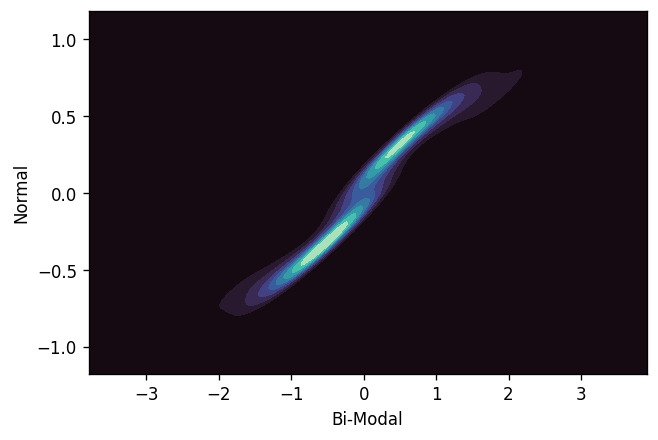

In [11]:
kde = sns.kdeplot(x=normal_dist_sample, y=bi_modal_sample, fill=True, thresh=0, level=100, cmap="mako",)
plt.ylabel('Normal')
plt.xlabel('Bi-Modal')
# plt.savefig(path_to_file + 'NormFlow_Bi-Modal-mako.png', dpi = 200)

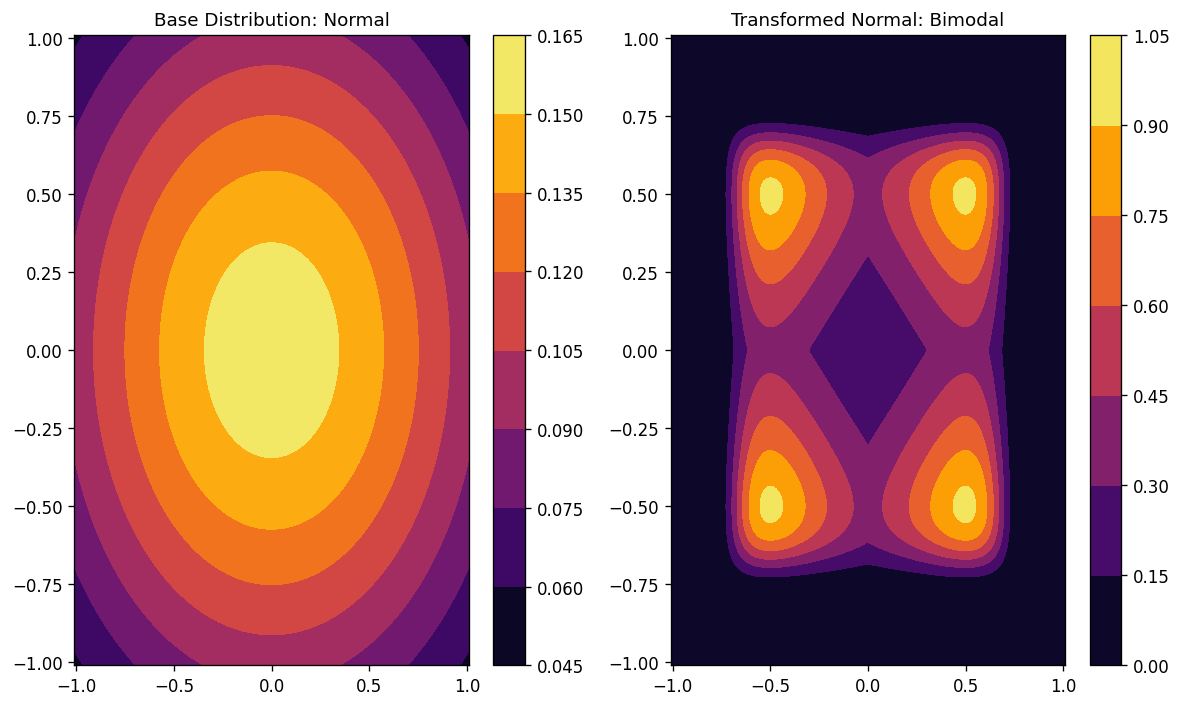

In [20]:
xx = np.linspace(-1.01, 1.01, 200)
yy = np.linspace(-1.01, 1.01, 200)

X, Y = np.meshgrid(xx, yy)
stacked_X_Y = np.dstack((X, Y))

tf.random.set_seed(1234)
normal_dist = tfd.Normal(loc=0., scale=1.0) # starting base distribution

scale_b = tfb.Scale(1.)

bimodal_normal = tfd.TransformedDistribution(tfd.Sample(normal_dist, sample_shape=[2]), softsign,)
normal_normal = tfd.TransformedDistribution(tfd.Sample(normal_dist, sample_shape=[2]), scale_b,)

Z_BiMod = bimodal_normal.prob(stacked_X_Y)
# print (Z_BiMod)
Z_Norm = normal_normal.prob(stacked_X_Y)
# print (Z_Norm)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
prob_contour = axs[0].contourf(X, Y, Z_Norm, cmap=plt.cm.inferno)
fig.colorbar(prob_contour, ax=axs[0])
axs[0].set_title(r'Base Distribution: Normal', fontsize=11)
axs[1].set_title(r'Transformed Normal: Bimodal', fontsize=11)
prob_contour_norm = axs[1].contourf(X, Y, Z_BiMod, cmap=plt.cm.inferno)
fig.colorbar(prob_contour_norm, ax=axs[1])
plt.tight_layout()
plt.savefig(path_to_file + 'NormFlow_Bi-Modal-Cmap.png', dpi = 200)
plt.show()

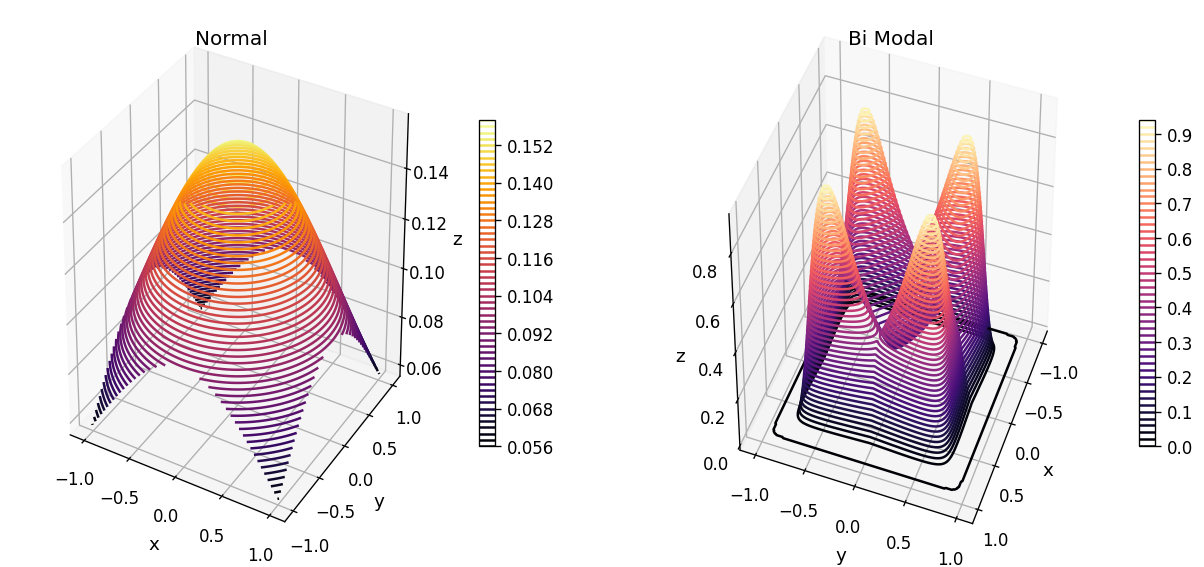

In [15]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
cont3d_norm = ax1.contour3D(X, Y, Z_Norm, 50, cmap='inferno')
fig.colorbar(cont3d_norm, shrink=0.6)
ax1.set_title('Normal', fontsize=12)
ax1.set_xlabel('x', fontsize=11)
ax1.set_ylabel('y', fontsize=11)
ax1.set_zlabel('z', fontsize=11)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
cont3d_bimod = ax2.contour3D(X, Y, Z_BiMod, 50, cmap='magma')
fig.colorbar(cont3d_bimod, shrink=0.6)
ax2.set_xlabel('x', fontsize=11)
ax2.set_ylabel('y', fontsize=11)
ax2.set_zlabel('z', fontsize=11)
ax2.set_title('Bi Modal', fontsize=12)
ax2.view_init(40, 20)
#plt.tight_layout()
plt.savefig(path_to_file + 'NormFlow_Bi-Modal3d.png', dpi = 200)
plt.show()

In [ ]:
print("TF version:", tf.__version__)
print("TF Prob. version:", tfp.__version__)
print ("numpy version; ", np.__version__)
print("seabon version: ", sns.__version__)
print ()

TF version: 2.9.2
TF Prob. version: 0.16.0
numpy version;  1.21.6
seabon version:  0.11.2



#### Next Stop: Normalizing Flow 